In [91]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import sklearn.datasets

In [92]:
#Device agnostic

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a dataset for multiclass classification

In [93]:
#Make a dataset for classification

import numpy as np

n_samples = 10000

X,Y = sklearn.datasets.make_blobs(n_samples = n_samples, n_features = 2, centers = 8, cluster_std = 1, random_state = 158)

X[:10], Y[:10]

(array([[-9.22746103, -8.88717558],
        [-6.34932401, -6.6558209 ],
        [ 3.77861126,  2.79375938],
        [ 0.11480801, -0.39827261],
        [-8.12077326, -7.87562599],
        [ 3.87729116,  2.15826863],
        [ 4.67577469,  5.04879172],
        [ 8.10761842, -5.33168768],
        [-6.41526193, -8.0470105 ],
        [ 5.48941072, -4.16073068]]),
 array([0, 0, 3, 1, 0, 1, 2, 6, 0, 6]))

In [94]:
#Convert into tensor and split data

X, Y = torch.from_numpy(X).type(torch.float32), torch.from_numpy(Y).type(torch.LongTensor)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 158)

In [95]:
#Check data format, shape, len

print(f"Len of train datasets : {len(X_train)}, Len of test datasets : {len(Y_test)}")
print(f"Dtype of data : {X_train.dtype}, {Y_train.dtype}")

Len of train datasets : 8000, Len of test datasets : 2000
Dtype of data : torch.float32, torch.int64


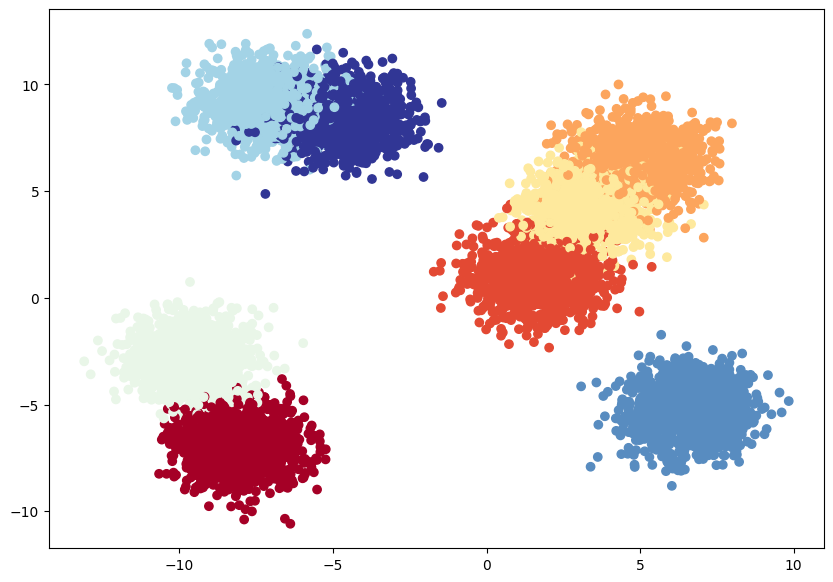

In [96]:
#Visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.scatter(x=X[:,0], y = X[:,1], c = Y[:], cmap = "RdYlBu")

# Design a model


In [104]:
#Create a model

print()
class BlobClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_stack_layers = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 64),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 8) #THE OUTPUT SIZE = THE NUM OF CLASS
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
      return self.linear_stack_layers(x)

model = BlobClassificationModel().to(device)
model

BlobClassificationModel(
  (linear_stack_layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [105]:
#Pick loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.03)

In [106]:
#Accuracy function

def accuracy_fn( y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100

  return acc

# Training Loop

In [107]:
#Put datasets on device
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

epochs = 1000

#Training loop
for epoch in range(epochs):
  model.train()

  train_logits = model(X_train)
  train_pred = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)

  train_loss = loss_fn(train_logits, Y_train)
  train_acc = accuracy_fn(Y_train, train_pred)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  #Evaluation
  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)

    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(Y_test, test_pred)


  #Visualize the training state for each 100 epochs

  if epoch%100 == 0:
    print(f"Epoch : {epoch} | Training loss : {train_loss:.4f}, Training accuracy : {train_acc: .2f}% | Test loss : {test_loss : .4f}, Test accuracy = {test_acc : .2f}%")





Epoch : 0 | Training loss : 2.0935, Training accuracy :  12.61% | Test loss :  2.0927, Test accuracy =  12.05%
Epoch : 100 | Training loss : 1.9974, Training accuracy :  54.27% | Test loss :  1.9989, Test accuracy =  53.75%
Epoch : 200 | Training loss : 1.1789, Training accuracy :  62.38% | Test loss :  1.1870, Test accuracy =  61.65%
Epoch : 300 | Training loss : 0.5484, Training accuracy :  77.40% | Test loss :  0.5568, Test accuracy =  75.95%
Epoch : 400 | Training loss : 0.4396, Training accuracy :  79.44% | Test loss :  0.4394, Test accuracy =  81.90%
Epoch : 500 | Training loss : 0.3767, Training accuracy :  81.96% | Test loss :  0.3708, Test accuracy =  87.05%
Epoch : 600 | Training loss : 0.3469, Training accuracy :  82.61% | Test loss :  0.3346, Test accuracy =  87.70%
Epoch : 700 | Training loss : 0.3242, Training accuracy :  83.69% | Test loss :  0.3030, Test accuracy =  88.95%
Epoch : 800 | Training loss : 0.3158, Training accuracy :  84.14% | Test loss :  0.2750, Test accu

In [108]:
#Graph the prediction to evaluate the model

import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("hepler.function.py already exist, skipping download")
else:
  print("Download helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_decision_boundary

hepler.function.py already exist, skipping download


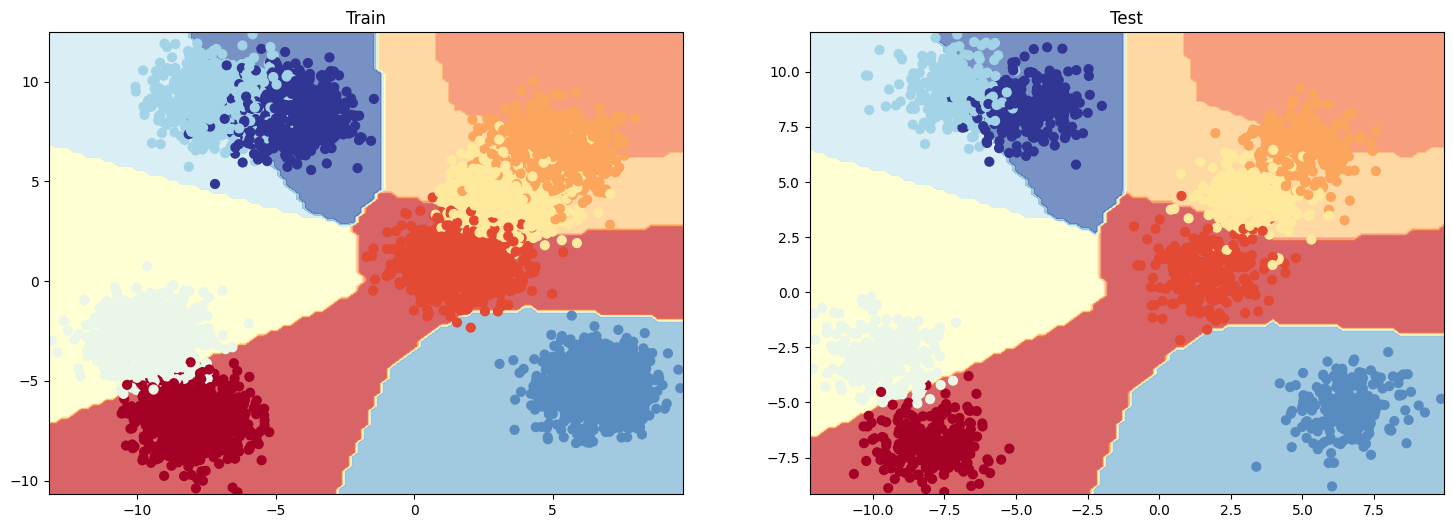

In [109]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, Y_test)

In [111]:
#Save the model
from pathlib import Path

MODEL_PATH = Path("multiclass_classification_model")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_SAVE_NAME = "my_model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_SAVE_NAME

MODEL_SAVE_PATH

PosixPath('multiclass_classification_model/my_model.pth')

In [112]:
torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)